# CPD using TIRE

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import warnings
import time, copy

import utils
import TIRE
import simulate

## Set parameters

#### alpha settings

In [26]:
# window_size = 100
# domain = "both" #choose from: TD (time domain), FD (frequency domain) or both

# #parameters TD
# intermediate_dim_TD=0
# latent_dim_TD=1 #h^TD in paper
# nr_shared_TD=1 #s^TD in paper
# K_TD = 2 #as in paper
# nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
# loss_weight_TD=1 #lambda_TD in paper

# #parameters FD
# intermediate_dim_FD=0
# latent_dim_FD=1 #h^FD in paper
# nr_shared_FD=1 #s^FD in paper
# K_FD = 2 #as in paper
# nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
# loss_weight_FD=1 #lambda^FD in paper
# nfft = 30 #number of points for DFT
# norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

#### beta settings


In [27]:
window_size = 100
domain = "both" #choose from: TD (time domain), FD (frequency domain) or both

#parameters TD
intermediate_dim_TD=0
latent_dim_TD=3 #h^TD in paper
nr_shared_TD=2 #s^TD in paper
K_TD = 2 #as in paper
nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
loss_weight_TD=1 #lambda_TD in paper

#parameters FD
intermediate_dim_FD=10
latent_dim_FD=1 #h^FD in paper
nr_shared_FD=1 #s^FD in paper
K_FD = 2 #as in paper
nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
loss_weight_FD=1 #lambda^FD in paper
nfft = 30 #number of points for DFT
norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

## Generate data

In [28]:

# timeseries, windows_TD, parameters = simulate.generate_jumpingmean(window_size)
# windows_FD = utils.calc_fft(windows_TD, nfft, norm_mode)

# plt.figure(figsize=(15,4))
# plt.plot(timeseries)
# plt.show()
# plt.figure(figsize=(15,4))
# plt.plot(range(4000,4500),timeseries[4000:4500])
# plt.show()

In [29]:
# import utils
# # parameter is only used for generate groundtruth, so if we can replace by our groundtruth, it's fine
# breakpoints_origin = utils.parameters_to_cps(parameters, window_size) # len(breakpoints) = len(timeseries) = 2*window_size + 1
# print(f'breakpoints shape: {breakpoints_origin.shape}, value: {breakpoints_origin[:10]}')
# breakpoints_index = np.where(breakpoints_origin > 0)[0]

# # len(breakpoints) = len(timeseries) - 2*window_size + 1
# print(f'len: {len(breakpoints_index)}, value: {breakpoints_index}')
# breakpoints = np.array([0] * (len(timeseries) - 2*window_size + 1))

# breakpoints[breakpoints_index] = [1]*len(breakpoints_index)


In [30]:
# load time series from file 
# import json
# data_file = './data/quality_control_3.json'
# with open(data_file, mode='r') as f:
#     data = json.load(f)
#     series = data['series']
#     timeseries = series[0]['raw']
#     timeseries = np.array(timeseries)

In [31]:
# load hasc data 
data_file = './data/preprocess/hasc_l2_norm.csv'
breakpoints_index_file = './data/preprocess/hasc_label_index.txt'

ts_df = pd.read_csv(data_file)
timeseries = ts_df['l2_norm'].to_numpy()

breakpoints_df = pd.read_csv(breakpoints_index_file, header=None)
breakpoints_index = breakpoints_df[0].to_numpy()
breakpoints_index = breakpoints_index - window_size # change index because we reduce the length of breakpoints 

In [32]:
'''
1. Generate time series, 
2. convert time series into window_TD
3. Convert time serites into window_FD
4. Create groundtruth
'''
windows_TD = utils.ts_to_windows(timeseries, 0, window_size, 1)
windows_TD = utils.minmaxscale(windows_TD,-1,1)
windows_FD = utils.calc_fft(windows_TD, nfft, norm_mode)

# len(breakpoints) = len(timeseries) - 2*window_size + 1
# breakpoints_index = [179]
print(f'len: {len(breakpoints_index)}, value: {breakpoints_index}')
breakpoints = np.array([0] * (len(timeseries) - 2*window_size + 1))

breakpoints[breakpoints_index] = [1]*len(breakpoints_index)
print(len(timeseries), len(breakpoints))

len: 39, value: [ 3859  5205  7712 10400 10465 12386 12984 13866 14145 14311 18282 18328
 19801 20957 20986 21438 24136 24369 24718 24784 25114 25610 25680 26410
 27308 27331 28001 28016 28296 29916 29972 30307 30678 30758 33467 34165
 35429 37411 37687]
39397 39198


## Train the autoencoders

In [33]:
shared_features_TD = TIRE.train_AE(windows_TD, intermediate_dim_TD, latent_dim_TD, nr_shared_TD, nr_ae_TD, loss_weight_TD, nr_patience=200)
shared_features_FD = TIRE.train_AE(windows_FD, intermediate_dim_FD, latent_dim_FD, nr_shared_FD, nr_ae_FD, loss_weight_FD, nr_patience=200)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 3, 100)]     0           []                               
                                                                                                  
 dense_19 (Dense)               (None, 3, 2)         202         ['input_11[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 3, 1)         101         ['input_11[0][0]']               
                                                                                                  
 tf.concat_5 (TFOpLambda)       (None, 3, 3)         0           ['dense_19[0][0]',               
                                                                  'dense_20[0][0]']        

## Postprocessing and peak detection

In [34]:
#we calculate the smoothened dissimilarity measure and the corresponding prominence-based change point scores
from importlib import reload 
reload(TIRE)
print(f'shared_features_TD shape: {shared_features_TD.shape}')
dissimilarities = TIRE.smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
change_point_scores = TIRE.change_point_score(dissimilarities, window_size)

shared_features_TD shape: (39298, 2)


In [35]:
print(f'change point scores. shape: {change_point_scores.shape}, head 20: {change_point_scores[:20]}')

# save change point scores to text file
np.savetxt("change_point_scores.txt", change_point_scores)

change point scores. shape: (39397,), head 20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


CHANGED !!!!!!!!!!!!!!!!!!!


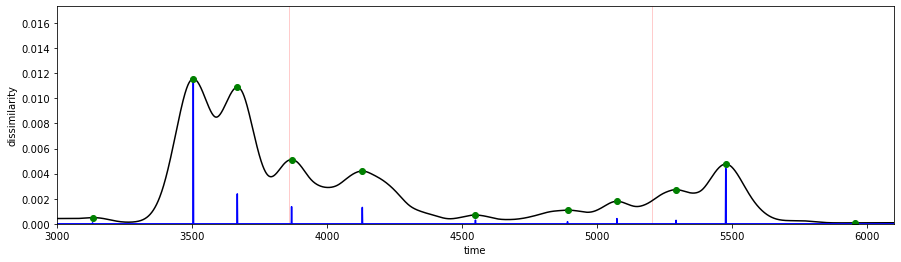

In [36]:
#parameters for plot
# import utils
from importlib import reload 
reload(utils)
time_start = 3000
time_stop = 6100
plot_prominences = True
'''
- green point: peak point based on simple comparasion with neighbour point (use scipy.signal)
- black line: disimilarity curve 
- vertical red line: groundtruth. But in this graph, it only use for the sake of example
- vertical blue: peak prominence (use scipy.singal)
'''

utils.plot_cp(dissimilarities, time_start, time_stop, plot_prominences, breakpoints)



mode: TD
[0.5241009352217013]


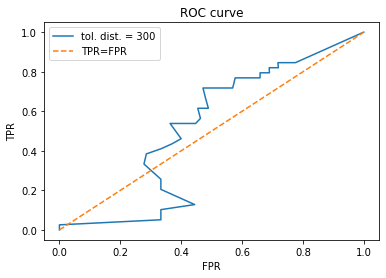

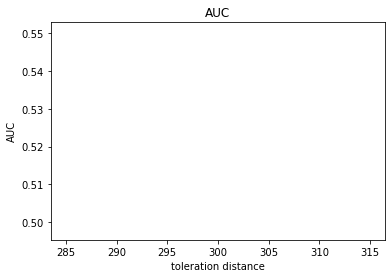

mode: FD
[0.6133735071043434]


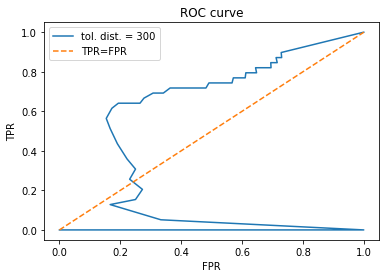

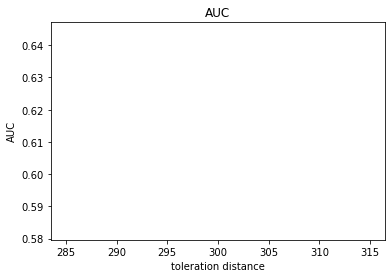

mode: both
[0.6139646902860879]


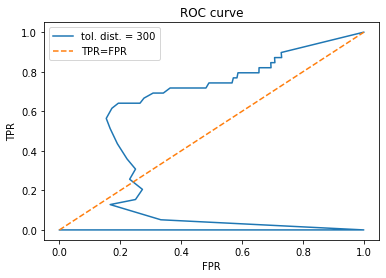

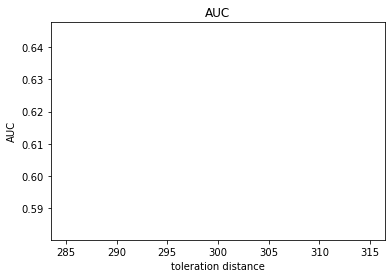

In [37]:
domains = ['TD', 'FD', 'both']
for domain in domains:
    dissimilarities = TIRE.smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
    change_point_scores = TIRE.change_point_score(dissimilarities, window_size)

    tol_distances = [300]
    print(f'mode: {domain}')
    auc = utils.get_auc(dissimilarities,tol_distances, breakpoints)